In [15]:
from datetime import datetime
import json

# Read lines from file
with open(r'TraderNet-CRv2/database/logs/trade_signals.log', 'r') as file:
    data_lines = file.readlines()

# Parse lines into list of dicts
signals = [json.loads(line.strip()) for line in data_lines if line.strip()]

# Sort signals by timestamp (just in case)
signals.sort(key=lambda x: x['timestamp'])

# Process buy → sell pairs
trades = []
current_buy = None

for signal in signals:
    if signal["type"].lower() == "buy":
        current_buy = signal
    elif signal["type"].lower() == "sell" and current_buy:
        buy_price = current_buy["price"]
        sell_price = signal["price"]
        qty = min(current_buy["quantity"], signal["quantity"])
        profit_pct = ((sell_price - buy_price) / buy_price) * 100
        trades.append({
            "buy_price": buy_price,
            "sell_price": sell_price,
            "quantity": qty,
            "profit_pct": profit_pct,
            "buy_time": datetime.utcfromtimestamp(current_buy["timestamp"] / 1000),
            "sell_time": datetime.utcfromtimestamp(signal["timestamp"] / 1000)
        })
        current_buy = None  # Reset for next pair

# Compute average profit percentage
average_profit = sum(t["profit_pct"] for t in trades) / len(trades) if trades else 0

# Print trades and summary
for t in trades:
    print(f"Buy at ₹{t['buy_price']} on {t['buy_time']} | "
          f"Sell at ₹{t['sell_price']} on {t['sell_time']} | "
          f"Profit: {t['profit_pct']:.2f}%")

print(f"\nAverage Profit Percentage: {average_profit:.2f}%")
sum(t["profit_pct"] for t in trades)


Buy at ₹12.35 on 2016-06-21 15:00:00 | Sell at ₹12.80127 on 2016-06-23 04:00:00 | Profit: 3.65%
Buy at ₹13.04 on 2016-06-23 10:00:00 | Sell at ₹12.84997 on 2016-06-23 13:00:00 | Profit: -1.46%
Buy at ₹13.97105 on 2016-06-24 10:00:00 | Sell at ₹14.23 on 2016-06-24 19:00:00 | Profit: 1.85%
Buy at ₹14.25102 on 2016-06-25 09:00:00 | Sell at ₹14.36889 on 2016-06-25 17:00:00 | Profit: 0.83%
Buy at ₹10.7 on 2016-07-05 08:00:00 | Sell at ₹10.48649 on 2016-07-06 21:00:00 | Profit: -2.00%
Buy at ₹11.13 on 2016-07-08 20:00:00 | Sell at ₹10.95009 on 2016-07-09 16:00:00 | Profit: -1.62%
Buy at ₹11.06049 on 2016-07-14 08:00:00 | Sell at ₹11.77 on 2016-07-16 06:00:00 | Profit: 6.41%
Buy at ₹11.999 on 2016-07-20 10:00:00 | Sell at ₹12.42 on 2016-07-21 17:00:00 | Profit: 3.51%
Buy at ₹14.22 on 2016-07-22 20:00:00 | Sell at ₹14.36 on 2016-07-23 21:00:00 | Profit: 0.98%
Buy at ₹11.05 on 2016-08-02 00:00:00 | Sell at ₹9.1 on 2016-08-03 02:00:00 | Profit: -17.65%
Buy at ₹9.10744 on 2016-08-03 09:00:00 | Se

370.5456086139433

In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time

def fetch_binance_trades(symbol="ETHUSDT", interval="1m", start_date="2018-01-01", end_date="2018-05-02"):
    url = "https://api.binance.com/api/v3/klines"

    # Convert datetime to milliseconds
    start_timestamp = int(datetime.strptime(start_date, "%Y-%m-%d").timestamp() * 1000)
    end_timestamp = int(datetime.strptime(end_date, "%Y-%m-%d").timestamp() * 1000)

    all_data = []
    limit = 1000  # Binance max per request

    while start_timestamp < end_timestamp:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_timestamp,
            "endTime": end_timestamp,
            "limit": limit
        }

        res = requests.get(url, params=params)
        data = res.json()

        if not data:
            break

        all_data.extend(data)

        # Update start_timestamp to fetch the next batch
        last_timestamp = data[-1][6]  # close_time of last candle
        start_timestamp = last_timestamp + 1  # move forward

        # Sleep to respect API rate limits
        time.sleep(0.1)

    # Convert to DataFrame
    df = pd.DataFrame(all_data, columns=[
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ])

    # Convert timestamps to human-readable format
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")

    # Keep relevant columns only
    df = df[["open_time", "close_time", "open", "high", "low", "close", "volume", "number_of_trades"]]
    return df

# Example usage
df = fetch_binance_trades(
    symbol="ETHUSDT",
    interval="5m",
    start_date="2023-01-01",
    end_date="2023-01-03"
)

print(df)
print(f"\nTotal candles fetched: {len(df)}")


              open_time              close_time           open           high  \
0   2022-12-31 18:30:00 2022-12-31 18:34:59.999  1200.18000000  1200.19000000   
1   2022-12-31 18:35:00 2022-12-31 18:39:59.999  1199.89000000  1200.08000000   
2   2022-12-31 18:40:00 2022-12-31 18:44:59.999  1199.71000000  1199.71000000   
3   2022-12-31 18:45:00 2022-12-31 18:49:59.999  1199.62000000  1200.33000000   
4   2022-12-31 18:50:00 2022-12-31 18:54:59.999  1199.77000000  1200.13000000   
..                  ...                     ...            ...            ...   
572 2023-01-02 18:10:00 2023-01-02 18:14:59.999  1216.87000000  1216.88000000   
573 2023-01-02 18:15:00 2023-01-02 18:19:59.999  1216.79000000  1217.36000000   
574 2023-01-02 18:20:00 2023-01-02 18:24:59.999  1217.35000000  1218.15000000   
575 2023-01-02 18:25:00 2023-01-02 18:29:59.999  1217.59000000  1218.12000000   
576 2023-01-02 18:30:00 2023-01-02 18:34:59.999  1217.84000000  1218.02000000   

               low         

In [ ]:
2022-12-31 18:30:00,1200.18,1200.19,1199.89,1199.89,2062.3413,2.499656297379832e-05,-0.0002582590852821,-0.0002083307299527,-0.0002499916682463,-0.2791985938314525,18,1200.02062769764,1378.783438513077,1202.585674458698,1198.837325541302,6931149.518842546,-5503568.603939983,-0.5922799473839859,-0.5829443628945344,-0.0093355844894514,39.21568627451505,46.15131612787305,20.0,44.0,37.24275982038145,23.960210781117407,-75.29355948286243,27.0,-0.0093355844894514,39.21568627451505,1199.988066450418,1378.783438513077,2.695674458698022,1.052674458697993,-4031.523016667925,664.2179999994114,2022-12-31 18:27:31,0.0
2022-12-31 18:35:00,1199.89,1200.08,1199.53,1199.71,4358.3497,-0.0002416596194371,-9.16563553909734e-05,-0.0003000725197767,-0.0001500250044487,0.7482515857222519,18,1199.8942087282808,1378.7829910160044,1202.217088473563,1198.8979115264372,6929643.9071280025,-5507926.953639983,-0.6085450980144742,-0.5880645099185224,-0.0204805880959517,11.25000000000302,36.10440663560024,16.0,40.0,35.86535614174784,24.5312766662456,-96.7729557576516,27.0,-0.0204805880959517,11.25000000000302,1199.8385931192695,1378.7829910160044,2.5070884735630443,0.8120884735628806,-3567.953014544212,-6420.691000000574,2022-12-31 18:32:31,0.0
2022-12-31 18:40:00,1199.71,1199.71,1199.62,1199.63,714.4107,-0.0001500250044487,-0.0003083603173042,7.502657194607978e-05,-6.668500506773932e-05,-1.80839074846238,18,1199.7745396061675,1378.7829176143505,1201.845716464833,1198.978283535167,6929088.254361339,-5508641.364339983,-0.6207352291578445,-0.5945986537663869,-0.0261365753914576,6.250000000007994,18.9052287581746,12.0,36.0,35.24151202901837,25.06155213100749,-111.17193558684328,27.0,-0.0261365753914576,6.250000000007994,1199.7078351663758,1378.7829176143505,2.2157164648328944,0.6517164648330436,-2061.264481207356,-5072.760400000028,2022-12-31 18:37:31,0.0

### Testing new 29-08-2025

In [24]:
import pandas as pd

# Read both CSVs
df2 = pd.read_csv(r"C:\Users\ujjwa_n18433z\Desktop\ujjwal\DAIICT\Minor Project\TraderNet-CRv2\experiments\integrated\PPO\ETH_Test_Market-Limit Orders_eval_cumul_pnls.csv")
df1 = pd.read_csv(r"C:\Users\ujjwa_n18433z\Desktop\ujjwal\DAIICT\Minor Project\TraderNet-CRv2\database\storage\datasets\Eth_Test_1h.csv")

# Concatenate row-wise
merged_df = pd.concat([df1[13:], df2], axis=1, ignore_index=True)

# Save to new file
merged_df.to_csv("merged.csv", index=False)

print(merged_df.head())


                     0        1        2        3        4             5   \
13  2023-03-31 00:00:00  1793.60  1809.32  1789.42  1805.43  1.878949e+06   
14  2023-03-31 01:00:00  1805.42  1817.99  1800.00  1802.35  2.993432e+06   
15  2023-03-31 02:00:00  1802.35  1805.61  1799.39  1803.18  8.848013e+05   
16  2023-03-31 03:00:00  1803.18  1808.72  1802.46  1803.22  9.262921e+05   
17  2023-03-31 04:00:00  1803.23  1805.46  1799.96  1804.71  8.981891e+05   

          6         7         8         9   ...         33         34  \
13  0.005103  0.005164  0.004245  0.006568  ...   7.938861  30.924861   
14  0.006568  0.004780  0.005895 -0.001707  ...  11.582269  27.886269   
15 -0.001702 -0.006833 -0.000339  0.000460  ...  11.476560  28.738560   
16  0.000460  0.001721  0.001705  0.000022  ...  10.935757  28.602757   
17  0.000028 -0.001804 -0.001388  0.000826  ...  10.138784  30.226784   

              35            36                   37            38        39  \
13  1.531245e+06  3

In [25]:
merged_df

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
13,2023-03-31 00:00:00,1793.60,1809.32,1789.42,1805.43,1.878949e+06,0.005103,0.005164,0.004245,0.006568,...,7.938861,30.924861,1.531245e+06,3.184850e+06,2023-03-30 23:02:31,1.241754e-11,-0.079970,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0
14,2023-03-31 01:00:00,1805.42,1817.99,1800.00,1802.35,2.993432e+06,0.006568,0.004780,0.005895,-0.001707,...,11.582269,27.886269,-1.067014e+06,-1.114483e+06,2023-03-31 00:02:31,1.399278e-15,-0.093019,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0
15,2023-03-31 02:00:00,1802.35,1805.61,1799.39,1803.18,8.848013e+05,-0.001702,-0.006833,-0.000339,0.000460,...,11.476560,28.738560,-2.017918e+06,-2.108631e+06,2023-03-31 01:02:31,1.576784e-19,-0.105333,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0
16,2023-03-31 03:00:00,1803.18,1808.72,1802.46,1803.22,9.262921e+05,0.000460,0.001721,0.001705,0.000022,...,10.935757,28.602757,-5.079163e+05,1.811093e+06,2023-03-31 02:02:31,1.776808e-23,-0.116266,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0
17,2023-03-31 04:00:00,1803.23,1805.46,1799.96,1804.71,8.981891e+05,0.000028,-0.001804,-0.001388,0.000826,...,10.138784,30.226784,-4.814930e+04,1.824481e+06,2023-03-31 03:02:31,2.002207e-27,-0.116266,2,"TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.039864,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.042233,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.045332,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.054218,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0


In [27]:
merged_df[[38]]

,38
13,1.241754e-11
14,1.399278e-15
15,1.576784e-19
16,1.776808e-23
17,2.002207e-27
...,...
8,NaN
9,NaN
10,NaN
11,NaN


In [28]:
merged_df.dropna(axis=0,inplace=True)

In [29]:
import matplotlib.pyplot as plt

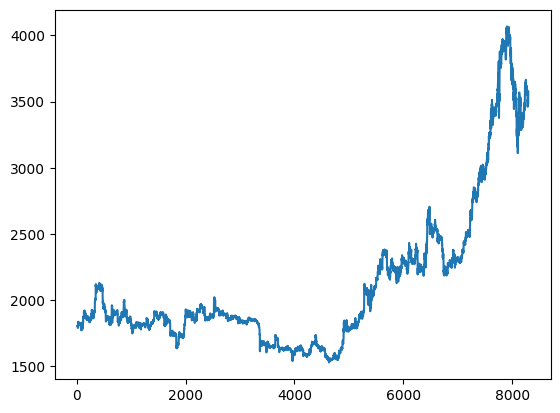

In [30]:
plt.plot(merged_df.index , merged_df[[4]])

In [20]:
df3=pd.read_csv(r"C:\Users\ujjwa_n18433z\Desktop\ujjwal\DAIICT\Minor Project\TraderNet-CRv2\database\storage\datasets\Eth_Train_1h.csv")

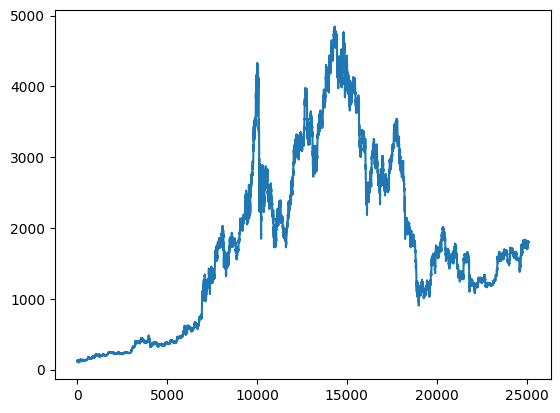

In [23]:
plt.plot(df3.index , df3[["close"]])

In [31]:
merged_df

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
13,2023-03-31 00:00:00,1793.60,1809.32,1789.42,1805.43,1.878949e+06,0.005103,0.005164,0.004245,0.006568,...,7.938861,30.924861,1.531245e+06,3.184850e+06,2023-03-30 23:02:31,1.241754e-11,-0.079970,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0
14,2023-03-31 01:00:00,1805.42,1817.99,1800.00,1802.35,2.993432e+06,0.006568,0.004780,0.005895,-0.001707,...,11.582269,27.886269,-1.067014e+06,-1.114483e+06,2023-03-31 00:02:31,1.399278e-15,-0.093019,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0
15,2023-03-31 02:00:00,1802.35,1805.61,1799.39,1803.18,8.848013e+05,-0.001702,-0.006833,-0.000339,0.000460,...,11.476560,28.738560,-2.017918e+06,-2.108631e+06,2023-03-31 01:02:31,1.576784e-19,-0.105333,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0
16,2023-03-31 03:00:00,1803.18,1808.72,1802.46,1803.22,9.262921e+05,0.000460,0.001721,0.001705,0.000022,...,10.935757,28.602757,-5.079163e+05,1.811093e+06,2023-03-31 02:02:31,1.776808e-23,-0.116266,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0
17,2023-03-31 04:00:00,1803.23,1805.46,1799.96,1804.71,8.981891e+05,0.000028,-0.001804,-0.001388,0.000826,...,10.138784,30.226784,-4.814930e+04,1.824481e+06,2023-03-31 03:02:31,2.002207e-27,-0.116266,2,"TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8294,2024-03-28 02:00:00,3496.40,3512.91,3465.00,3480.19,3.436501e+04,-0.005528,-0.002181,-0.007645,-0.004644,...,122.586727,25.096727,-3.808011e+04,-7.249927e+04,2024-03-28 01:02:31,3.096512e-29,73.969819,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0
8295,2024-03-28 03:00:00,3480.18,3498.89,3475.05,3496.61,1.047787e+04,-0.004650,-0.003999,0.002896,0.004707,...,102.047902,44.257902,-4.100249e+03,-2.388714e+04,2024-03-28 02:02:31,3.489323e-33,73.956283,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0
8296,2024-03-28 04:00:00,3496.61,3516.74,3495.79,3516.19,1.015676e+04,0.004710,0.005089,0.005951,0.005584,...,79.843233,64.715233,1.809719e+04,2.063463e+04,2024-03-28 03:02:31,3.931964e-37,73.955375,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0
8297,2024-03-28 05:00:00,3516.19,3542.37,3512.81,3533.70,2.012183e+04,0.005584,0.007262,0.004857,0.004967,...,56.800688,80.703688,1.794176e+04,3.027859e+04,2024-03-28 04:02:31,4.430756e-41,73.949544,"tf.Tensor([0], shape=(1,), dtype=int32)","TimeStep(\n{'discount': <tf.Tensor: shape=(1,)...",0.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# Load CSV
df = pd.read_csv(r"C:\Users\ujjwa_n18433z\Desktop\ujjwal\DAIICT\Minor Project\TraderNet-CRv2\experiments\integrated\DDQN\ETH_Market-Limit Orders_eval_cumul_pnlspriced.csv")

# Rename columns for clarity
df.columns = ["col1", "tensor", "price", "signal"]

# Keep only the columns we need
df = df[["price", "signal"]]

print(df.head())


     price  signal
0  2641.65       1
1  2642.81       1
2  2659.17       1
3  2667.97       1
4  2668.17       1


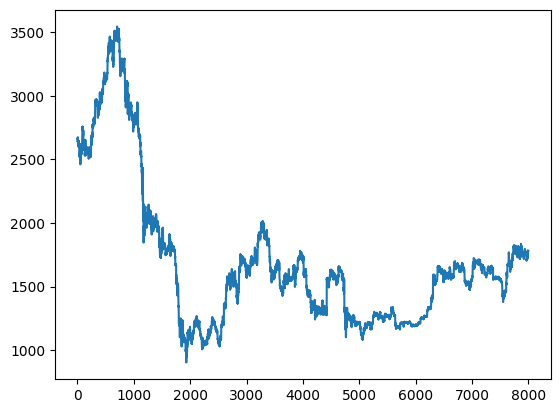

In [3]:
plt.plot(df.index , df[["price"]])